In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle as pkl
import time
from copy import deepcopy

from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn.functional as F
from torchvision.transforms import v2
torch.manual_seed(19)

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

In [2]:
transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPerspective(0.4),
    v2.ToDtype(torch.float32)
])

class NCarsImageDataset(Dataset):
    def __init__(self, img_dir_file, transform=None, target_transform=None):
        self.images = np.load(img_dir_file + '_x.npy')
        self.labels = np.load(img_dir_file + '_y.npy')
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        label_temp = np.zeros((10,))
        label_temp[label] = 1
        if self.stage == 0:
            return self.transform(torch.tensor(image)), torch.tensor(label_temp)
        else:
            return torch.tensor(image), torch.tensor(label_temp)
    
    def set_stage(self, stage):
        self.stage = stage

In [3]:
from torch.utils.data import DataLoader
data = NCarsImageDataset("./Datasety/CIFAR10-DVS_128", transform=transforms)

generator1 = torch.Generator().manual_seed(42)
test_data, training_data = torch.utils.data.random_split(data, [0.3, 0.7], generator=generator1)

del data

In [4]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, end_maxpool = False):
        super(ResidualBlock, self).__init__()
        if(downsample is not None):
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False),
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            )  # Changed inplace to False
        else:
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)
                            )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False))  # Changed inplace to False
        self.downsample = downsample
        self.relu = nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)  # Changed inplace to False
        self.out_channels = out_channels
        self.end_maxpool = end_maxpool

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        if self.end_maxpool:
            out = F.relu(out, inplace=False)
        else:
            out = F.hardtanh(out, inplace=False, min_val=-1.0, max_val=1.0)   # Use non-in-place ReLU
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 2, in_channels = 5):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 64, kernel_size = 7, stride = 1, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=False))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2, end_maxpool = True)
        self.avgpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1, end_maxpool = False):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
                nn.BatchNorm2d(planes),
                nn.ReLU(inplace=False),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            if i == blocks-1 and end_maxpool:
                layers.append(block(self.inplanes, planes, end_maxpool = True))
            else:
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.hardtanh(x)
        x = self.fc2(x)
        return x
    
    def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 0.94):
        best_accuracy = 0.0
        total_step = len(train_loader)
        train_accuracy_h = []
        test_accuracy_h = []
        train_loss_h = []
        test_loss_h = []
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.978)#LinearLR(optimizer,  start_factor=start_factor, end_factor=end_factor, total_iters=total_iters)
        for epoch in range(num_epochs):
            # self.train()
            correct = 0
            total = 0
            running_loss = 0.0
            train_loader.dataset.dataset.set_stage(0)
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.float().to("cuda")
                labels = labels.type(torch.FloatTensor)
                labels = labels.to("cuda")


                optimizer.zero_grad()

                # Forward pass
                outputs = self.forward(images)
                loss = criterion(outputs, labels)
                # Backward and optimize
                loss.backward()
                
                optimizer.step()

                # accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                total += labels.size(0)
                running_loss += loss.item()
                del images, labels, outputs
            train_accuracy_h.append((float(correct))/total)
            train_loss_h.append(running_loss/len(train_loader))
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, running_loss/len(train_loader), (float(correct))/total))

            scheduler.step()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                val_loss = 0.0
                valid_loader.dataset.dataset.set_stage(1)
                for images, labels in valid_loader:
                    images = images.float().to("cuda")
                    labels = labels.type(torch.FloatTensor)
                    labels = labels.to("cuda")
                    outputs = self.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    del images, labels, outputs
                if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
                    torch.save(self.state_dict(), "best_resnet50_CIFAR10-DVS_Hardtanh_ReLUmaxpool__128x128_FC2_128x128_pretrained_aug_corrected_trilinear2.pt")
                test_accuracy_h.append((float(correct))/total)
                test_loss_h.append(val_loss/len(valid_loader))
                print('Accuracy of the network: {} Loss: {}'.format( correct / total, val_loss/len(valid_loader)))
        return train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h

In [6]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
model_resnet = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes = 10, in_channels=6).to("cuda")
print(model_resnet)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (relu): Hardtanh(min_val=-1.0, max_val=1.0)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kerne

In [7]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)

Using cache found in C:\Users\nikos/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
size_layer = [3, 4, 6, 3]
layers = [(model_resnet.layer0, model.layer1), (model_resnet.layer1, model.layer2), (model_resnet.layer2, model.layer3), (model_resnet.layer3, model.layer4)]
for n in range(len(layers)):
    for i in range(size_layer[n]):
        layers[n][0][i].conv1[0] = layers[n][1][i].conv1
        layers[n][0][i].conv1[0].stride = 1
        layers[n][0][i].conv2[0] = layers[n][1][i].conv2
        layers[n][0][i].conv2[0].stride = 1
        
        layers[n][0][i].conv1[1] = layers[n][1][i].bn1
        layers[n][0][i].conv2[1] = layers[n][1][i].bn2

model_resnet.layer1[0].downsample[0] = model.layer2[0].downsample[0]
model_resnet.layer1[0].downsample[0].stride = 1
model_resnet.layer1[0].downsample[1] = model.layer2[0].downsample[1]

model_resnet.layer2[0].downsample[0] = model.layer3[0].downsample[0]
model_resnet.layer2[0].downsample[0].stride = 1
model_resnet.layer2[0].downsample[1] = model.layer3[0].downsample[1]

model_resnet.layer3[0].downsample[0] = model.layer4[0].downsample[0]
model_resnet.layer3[0].downsample[0].stride = 1
model_resnet.layer3[0].downsample[1] = model.layer4[0].downsample[1]

model_resnet.to("cuda")

ResNet(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (relu): Hardtanh(min_val=-1.0, max_val=1.0)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv

In [9]:
torch.autograd.set_detect_anomaly(True)
train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h = model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=300,save_best=True, save_thr=48)

100%|██████████| 219/219 [01:09<00:00,  3.16it/s]


Epoch [1/300], Step [219/219], Loss: 3.1797, Accuracy: 0.1026
Accuracy of the network: 0.098 Loss: 2.9262188317927906


100%|██████████| 219/219 [01:11<00:00,  3.06it/s]


Epoch [2/300], Step [219/219], Loss: 2.7738, Accuracy: 0.0976
Accuracy of the network: 0.1 Loss: 2.5091483263259238


100%|██████████| 219/219 [01:11<00:00,  3.07it/s]


Epoch [3/300], Step [219/219], Loss: 2.6413, Accuracy: 0.1134
Accuracy of the network: 0.095 Loss: 2.6416199968216265


100%|██████████| 219/219 [01:11<00:00,  3.07it/s]


Epoch [4/300], Step [219/219], Loss: 2.5111, Accuracy: 0.0999
Accuracy of the network: 0.12266666666666666 Loss: 2.4481125816385796


100%|██████████| 219/219 [01:11<00:00,  3.07it/s]


Epoch [5/300], Step [219/219], Loss: 2.3249, Accuracy: 0.1241
Accuracy of the network: 0.156 Loss: 2.2439400059111576


100%|██████████| 219/219 [01:11<00:00,  3.08it/s]


Epoch [6/300], Step [219/219], Loss: 2.2895, Accuracy: 0.1307
Accuracy of the network: 0.10766666666666666 Loss: 2.3096744836644922


100%|██████████| 219/219 [01:11<00:00,  3.07it/s]


Epoch [7/300], Step [219/219], Loss: 2.2350, Accuracy: 0.1509
Accuracy of the network: 0.17033333333333334 Loss: 2.148029072487608


100%|██████████| 219/219 [01:11<00:00,  3.07it/s]


Epoch [8/300], Step [219/219], Loss: 2.1789, Accuracy: 0.1637
Accuracy of the network: 0.18166666666666667 Loss: 2.1244182130123708


100%|██████████| 219/219 [01:11<00:00,  3.07it/s]


Epoch [9/300], Step [219/219], Loss: 2.1499, Accuracy: 0.1686
Accuracy of the network: 0.18666666666666668 Loss: 2.104446770028865


100%|██████████| 219/219 [01:11<00:00,  3.06it/s]


Epoch [10/300], Step [219/219], Loss: 2.1360, Accuracy: 0.1763
Accuracy of the network: 0.17066666666666666 Loss: 2.136991944718868


100%|██████████| 219/219 [01:11<00:00,  3.08it/s]


Epoch [11/300], Step [219/219], Loss: 2.1310, Accuracy: 0.1729
Accuracy of the network: 0.14933333333333335 Loss: 2.1968599976377283


100%|██████████| 219/219 [01:11<00:00,  3.06it/s]


Epoch [12/300], Step [219/219], Loss: 2.1511, Accuracy: 0.1729
Accuracy of the network: 0.16433333333333333 Loss: 2.1644268872890065


100%|██████████| 219/219 [01:11<00:00,  3.08it/s]


Epoch [13/300], Step [219/219], Loss: 2.1395, Accuracy: 0.1723
Accuracy of the network: 0.18 Loss: 2.142167806625366


100%|██████████| 219/219 [01:15<00:00,  2.92it/s]


Epoch [14/300], Step [219/219], Loss: 2.1157, Accuracy: 0.1834
Accuracy of the network: 0.17033333333333334 Loss: 2.1234723494407977


100%|██████████| 219/219 [01:12<00:00,  3.03it/s]


Epoch [15/300], Step [219/219], Loss: 2.1450, Accuracy: 0.1719
Accuracy of the network: 0.16733333333333333 Loss: 2.0965731511724757


100%|██████████| 219/219 [01:14<00:00,  2.92it/s]


Epoch [16/300], Step [219/219], Loss: 2.1299, Accuracy: 0.1717
Accuracy of the network: 0.18766666666666668 Loss: 2.140140953216147


100%|██████████| 219/219 [01:16<00:00,  2.86it/s]


Epoch [17/300], Step [219/219], Loss: 2.1110, Accuracy: 0.1850
Accuracy of the network: 0.16266666666666665 Loss: 2.1587275685148035


100%|██████████| 219/219 [01:15<00:00,  2.89it/s]


Epoch [18/300], Step [219/219], Loss: 2.1311, Accuracy: 0.1743
Accuracy of the network: 0.19 Loss: 2.118206041924497


100%|██████████| 219/219 [01:15<00:00,  2.88it/s]


Epoch [19/300], Step [219/219], Loss: 2.1236, Accuracy: 0.1817
Accuracy of the network: 0.16266666666666665 Loss: 2.103837841368736


100%|██████████| 219/219 [01:15<00:00,  2.91it/s]


Epoch [20/300], Step [219/219], Loss: 2.1221, Accuracy: 0.1677
Accuracy of the network: 0.16533333333333333 Loss: 2.1670550386956395


100%|██████████| 219/219 [01:15<00:00,  2.89it/s]


Epoch [21/300], Step [219/219], Loss: 2.1208, Accuracy: 0.1791
Accuracy of the network: 0.18966666666666668 Loss: 2.0884157558704946


100%|██████████| 219/219 [01:15<00:00,  2.88it/s]


Epoch [22/300], Step [219/219], Loss: 2.1024, Accuracy: 0.1830
Accuracy of the network: 0.189 Loss: 2.1273962576338588


100%|██████████| 219/219 [01:15<00:00,  2.92it/s]


Epoch [23/300], Step [219/219], Loss: 2.1106, Accuracy: 0.1799
Accuracy of the network: 0.19333333333333333 Loss: 2.0963268470256886


100%|██████████| 219/219 [01:14<00:00,  2.92it/s]


Epoch [24/300], Step [219/219], Loss: 2.1131, Accuracy: 0.1757
Accuracy of the network: 0.16166666666666665 Loss: 2.1568228868727988


100%|██████████| 219/219 [01:15<00:00,  2.90it/s]


Epoch [25/300], Step [219/219], Loss: 2.1091, Accuracy: 0.1796
Accuracy of the network: 0.19466666666666665 Loss: 2.087648313096229


100%|██████████| 219/219 [01:15<00:00,  2.90it/s]


Epoch [26/300], Step [219/219], Loss: 2.1122, Accuracy: 0.1804
Accuracy of the network: 0.143 Loss: 2.2259149538709764


100%|██████████| 219/219 [01:15<00:00,  2.91it/s]


Epoch [27/300], Step [219/219], Loss: 2.1257, Accuracy: 0.1804
Accuracy of the network: 0.16866666666666666 Loss: 2.2426865265724505


100%|██████████| 219/219 [01:13<00:00,  2.99it/s]


Epoch [28/300], Step [219/219], Loss: 2.1130, Accuracy: 0.1876
Accuracy of the network: 0.19366666666666665 Loss: 2.094206175905593


100%|██████████| 219/219 [01:09<00:00,  3.17it/s]


Epoch [29/300], Step [219/219], Loss: 2.1071, Accuracy: 0.1771
Accuracy of the network: 0.18533333333333332 Loss: 2.0939065674518016


100%|██████████| 219/219 [01:09<00:00,  3.16it/s]


Epoch [30/300], Step [219/219], Loss: 2.0977, Accuracy: 0.1794
Accuracy of the network: 0.122 Loss: 2.2949765819184322


100%|██████████| 219/219 [01:11<00:00,  3.07it/s]


Epoch [31/300], Step [219/219], Loss: 2.1147, Accuracy: 0.1763
Accuracy of the network: 0.205 Loss: 2.089247858270686


100%|██████████| 219/219 [01:10<00:00,  3.13it/s]


Epoch [32/300], Step [219/219], Loss: 2.0936, Accuracy: 0.1847
Accuracy of the network: 0.20033333333333334 Loss: 2.072758858508252


100%|██████████| 219/219 [01:10<00:00,  3.10it/s]


Epoch [33/300], Step [219/219], Loss: 2.1012, Accuracy: 0.1779
Accuracy of the network: 0.158 Loss: 2.0981084526853357


100%|██████████| 219/219 [01:10<00:00,  3.11it/s]


Epoch [34/300], Step [219/219], Loss: 2.1085, Accuracy: 0.1811
Accuracy of the network: 0.21166666666666667 Loss: 2.0920859359680337


100%|██████████| 219/219 [01:10<00:00,  3.13it/s]


Epoch [35/300], Step [219/219], Loss: 2.1037, Accuracy: 0.1789
Accuracy of the network: 0.14333333333333334 Loss: 2.1361412114285407


100%|██████████| 219/219 [01:08<00:00,  3.17it/s]


Epoch [36/300], Step [219/219], Loss: 2.1159, Accuracy: 0.1791
Accuracy of the network: 0.171 Loss: 2.1014761759879743


100%|██████████| 219/219 [01:09<00:00,  3.17it/s]


Epoch [37/300], Step [219/219], Loss: 2.0878, Accuracy: 0.1794
Accuracy of the network: 0.188 Loss: 2.0635207815373198


100%|██████████| 219/219 [01:13<00:00,  2.97it/s]


Epoch [38/300], Step [219/219], Loss: 2.0902, Accuracy: 0.1864
Accuracy of the network: 0.185 Loss: 2.0865193453240902


100%|██████████| 219/219 [01:15<00:00,  2.92it/s]


Epoch [39/300], Step [219/219], Loss: 2.0898, Accuracy: 0.1826
Accuracy of the network: 0.19366666666666665 Loss: 2.0584185212216477


100%|██████████| 219/219 [01:15<00:00,  2.90it/s]


Epoch [40/300], Step [219/219], Loss: 2.0812, Accuracy: 0.1919
Accuracy of the network: 0.154 Loss: 2.136288920615582


100%|██████████| 219/219 [01:10<00:00,  3.09it/s]


Epoch [41/300], Step [219/219], Loss: 2.0935, Accuracy: 0.1836
Accuracy of the network: 0.20833333333333334 Loss: 2.0901681907633516


100%|██████████| 219/219 [01:15<00:00,  2.89it/s]


Epoch [42/300], Step [219/219], Loss: 2.0837, Accuracy: 0.1869
Accuracy of the network: 0.219 Loss: 2.0501462525509773


100%|██████████| 219/219 [01:15<00:00,  2.90it/s]


Epoch [43/300], Step [219/219], Loss: 2.0849, Accuracy: 0.1866
Accuracy of the network: 0.18633333333333332 Loss: 2.079960159798886


100%|██████████| 219/219 [01:14<00:00,  2.93it/s]


Epoch [44/300], Step [219/219], Loss: 2.0751, Accuracy: 0.1881
Accuracy of the network: 0.19066666666666668 Loss: 2.0675457792079195


100%|██████████| 219/219 [01:14<00:00,  2.95it/s]


Epoch [45/300], Step [219/219], Loss: 2.0825, Accuracy: 0.1866
Accuracy of the network: 0.18366666666666667 Loss: 2.076535125996204


100%|██████████| 219/219 [01:14<00:00,  2.92it/s]


Epoch [46/300], Step [219/219], Loss: 2.0814, Accuracy: 0.1870
Accuracy of the network: 0.175 Loss: 2.108453370155172


100%|██████████| 219/219 [01:07<00:00,  3.24it/s]


Epoch [47/300], Step [219/219], Loss: 2.0804, Accuracy: 0.1926
Accuracy of the network: 0.185 Loss: 2.122190975128336


100%|██████████| 219/219 [01:07<00:00,  3.25it/s]


Epoch [48/300], Step [219/219], Loss: 2.0772, Accuracy: 0.1873
Accuracy of the network: 0.18366666666666667 Loss: 2.1254086633946034


100%|██████████| 219/219 [01:07<00:00,  3.27it/s]


Epoch [49/300], Step [219/219], Loss: 2.0714, Accuracy: 0.1940
Accuracy of the network: 0.20433333333333334 Loss: 2.0593887402656232


100%|██████████| 219/219 [01:08<00:00,  3.22it/s]


Epoch [50/300], Step [219/219], Loss: 2.0755, Accuracy: 0.1913
Accuracy of the network: 0.17766666666666667 Loss: 2.1159681195908404


100%|██████████| 219/219 [01:10<00:00,  3.11it/s]


Epoch [51/300], Step [219/219], Loss: 2.0678, Accuracy: 0.1911
Accuracy of the network: 0.183 Loss: 2.071473150811297


100%|██████████| 219/219 [01:14<00:00,  2.95it/s]


Epoch [52/300], Step [219/219], Loss: 2.0778, Accuracy: 0.1961
Accuracy of the network: 0.19766666666666666 Loss: 2.0776094401136356


100%|██████████| 219/219 [01:15<00:00,  2.91it/s]


Epoch [53/300], Step [219/219], Loss: 2.0639, Accuracy: 0.1940
Accuracy of the network: 0.195 Loss: 2.0646464964176747


100%|██████████| 219/219 [01:14<00:00,  2.93it/s]


Epoch [54/300], Step [219/219], Loss: 2.0630, Accuracy: 0.1986
Accuracy of the network: 0.203 Loss: 2.064447080835383


100%|██████████| 219/219 [01:10<00:00,  3.10it/s]


Epoch [55/300], Step [219/219], Loss: 2.0445, Accuracy: 0.2179
Accuracy of the network: 0.23866666666666667 Loss: 2.013714993253667


100%|██████████| 219/219 [01:10<00:00,  3.13it/s]


Epoch [56/300], Step [219/219], Loss: 2.0068, Accuracy: 0.2411
Accuracy of the network: 0.24766666666666667 Loss: 1.9827130703215903


100%|██████████| 219/219 [01:13<00:00,  2.99it/s]


Epoch [57/300], Step [219/219], Loss: 1.9851, Accuracy: 0.2561
Accuracy of the network: 0.24633333333333332 Loss: 2.0066785305104355


100%|██████████| 219/219 [01:14<00:00,  2.95it/s]


Epoch [58/300], Step [219/219], Loss: 1.9711, Accuracy: 0.2516
Accuracy of the network: 0.263 Loss: 1.9627321806359799


100%|██████████| 219/219 [01:14<00:00,  2.96it/s]


Epoch [59/300], Step [219/219], Loss: 1.9509, Accuracy: 0.2690
Accuracy of the network: 0.269 Loss: 1.9157850666249052


100%|██████████| 219/219 [01:14<00:00,  2.92it/s]


Epoch [60/300], Step [219/219], Loss: 1.9080, Accuracy: 0.2844
Accuracy of the network: 0.2796666666666667 Loss: 1.9139986608890778


100%|██████████| 219/219 [01:10<00:00,  3.10it/s]


Epoch [61/300], Step [219/219], Loss: 1.8888, Accuracy: 0.2964
Accuracy of the network: 0.288 Loss: 1.9039477883501257


100%|██████████| 219/219 [01:13<00:00,  2.99it/s]


Epoch [62/300], Step [219/219], Loss: 1.8821, Accuracy: 0.3034
Accuracy of the network: 0.30466666666666664 Loss: 1.8726154477038282


100%|██████████| 219/219 [01:13<00:00,  3.00it/s]


Epoch [63/300], Step [219/219], Loss: 1.8839, Accuracy: 0.2989
Accuracy of the network: 0.2803333333333333 Loss: 1.8984471217114876


100%|██████████| 219/219 [01:10<00:00,  3.10it/s]


Epoch [64/300], Step [219/219], Loss: 1.8633, Accuracy: 0.3039
Accuracy of the network: 0.327 Loss: 1.8491575603789472


100%|██████████| 219/219 [01:08<00:00,  3.22it/s]


Epoch [65/300], Step [219/219], Loss: 1.8662, Accuracy: 0.3054
Accuracy of the network: 0.30566666666666664 Loss: 1.8824549101768655


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [66/300], Step [219/219], Loss: 1.8456, Accuracy: 0.3103
Accuracy of the network: 0.315 Loss: 1.846210498759087


100%|██████████| 219/219 [01:07<00:00,  3.25it/s]


Epoch [67/300], Step [219/219], Loss: 1.8523, Accuracy: 0.3027
Accuracy of the network: 0.30933333333333335 Loss: 1.8504274994768994


100%|██████████| 219/219 [01:13<00:00,  2.97it/s]


Epoch [68/300], Step [219/219], Loss: 1.8296, Accuracy: 0.3159
Accuracy of the network: 0.33166666666666667 Loss: 1.837586430793113


100%|██████████| 219/219 [01:15<00:00,  2.89it/s]


Epoch [69/300], Step [219/219], Loss: 1.8239, Accuracy: 0.3190
Accuracy of the network: 0.298 Loss: 1.8785975283764778


100%|██████████| 219/219 [01:14<00:00,  2.93it/s]


Epoch [70/300], Step [219/219], Loss: 1.8252, Accuracy: 0.3159
Accuracy of the network: 0.30466666666666664 Loss: 1.8489846130634875


100%|██████████| 219/219 [01:14<00:00,  2.93it/s]


Epoch [71/300], Step [219/219], Loss: 1.8117, Accuracy: 0.3256
Accuracy of the network: 0.31366666666666665 Loss: 1.8439079649904941


100%|██████████| 219/219 [01:15<00:00,  2.90it/s]


Epoch [72/300], Step [219/219], Loss: 1.8042, Accuracy: 0.3259
Accuracy of the network: 0.33266666666666667 Loss: 1.8098313871850358


100%|██████████| 219/219 [01:12<00:00,  3.02it/s]


Epoch [73/300], Step [219/219], Loss: 1.7945, Accuracy: 0.3324
Accuracy of the network: 0.31566666666666665 Loss: 1.812838206899927


100%|██████████| 219/219 [01:09<00:00,  3.14it/s]


Epoch [74/300], Step [219/219], Loss: 1.7985, Accuracy: 0.3333
Accuracy of the network: 0.338 Loss: 1.7841416914412316


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [75/300], Step [219/219], Loss: 1.7763, Accuracy: 0.3441
Accuracy of the network: 0.347 Loss: 1.7855217050998768


100%|██████████| 219/219 [01:07<00:00,  3.25it/s]


Epoch [76/300], Step [219/219], Loss: 1.7762, Accuracy: 0.3416
Accuracy of the network: 0.361 Loss: 1.7765687742131822


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [77/300], Step [219/219], Loss: 1.7528, Accuracy: 0.3444
Accuracy of the network: 0.33266666666666667 Loss: 1.7782678249034476


100%|██████████| 219/219 [01:08<00:00,  3.18it/s]


Epoch [78/300], Step [219/219], Loss: 1.7633, Accuracy: 0.3497
Accuracy of the network: 0.35733333333333334 Loss: 1.7667744958654363


100%|██████████| 219/219 [01:07<00:00,  3.25it/s]


Epoch [79/300], Step [219/219], Loss: 1.7355, Accuracy: 0.3557
Accuracy of the network: 0.361 Loss: 1.7544652819633484


100%|██████████| 219/219 [01:07<00:00,  3.24it/s]


Epoch [80/300], Step [219/219], Loss: 1.7193, Accuracy: 0.3601
Accuracy of the network: 0.3486666666666667 Loss: 1.7735490481904213


100%|██████████| 219/219 [01:07<00:00,  3.23it/s]


Epoch [81/300], Step [219/219], Loss: 1.7275, Accuracy: 0.3611
Accuracy of the network: 0.33766666666666667 Loss: 1.8034836294803214


100%|██████████| 219/219 [01:07<00:00,  3.24it/s]


Epoch [82/300], Step [219/219], Loss: 1.7136, Accuracy: 0.3701
Accuracy of the network: 0.379 Loss: 1.7013226646058104


100%|██████████| 219/219 [01:08<00:00,  3.18it/s]


Epoch [83/300], Step [219/219], Loss: 1.7063, Accuracy: 0.3639
Accuracy of the network: 0.345 Loss: 1.7699063242749964


100%|██████████| 219/219 [01:07<00:00,  3.23it/s]


Epoch [84/300], Step [219/219], Loss: 1.7049, Accuracy: 0.3671
Accuracy of the network: 0.37633333333333335 Loss: 1.7173975008599303


100%|██████████| 219/219 [01:07<00:00,  3.23it/s]


Epoch [85/300], Step [219/219], Loss: 1.6908, Accuracy: 0.3739
Accuracy of the network: 0.346 Loss: 1.7513139856622575


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [86/300], Step [219/219], Loss: 1.6982, Accuracy: 0.3734
Accuracy of the network: 0.38533333333333336 Loss: 1.694882040328168


100%|██████████| 219/219 [01:07<00:00,  3.22it/s]


Epoch [87/300], Step [219/219], Loss: 1.6845, Accuracy: 0.3821
Accuracy of the network: 0.38133333333333336 Loss: 1.6918504593220163


100%|██████████| 219/219 [01:07<00:00,  3.25it/s]


Epoch [88/300], Step [219/219], Loss: 1.6763, Accuracy: 0.3871
Accuracy of the network: 0.37733333333333335 Loss: 1.6996076690389754


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [89/300], Step [219/219], Loss: 1.6714, Accuracy: 0.3819
Accuracy of the network: 0.38066666666666665 Loss: 1.6782790447803253


100%|██████████| 219/219 [01:07<00:00,  3.24it/s]


Epoch [90/300], Step [219/219], Loss: 1.6534, Accuracy: 0.3857
Accuracy of the network: 0.38966666666666666 Loss: 1.6750898754343073


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [91/300], Step [219/219], Loss: 1.6539, Accuracy: 0.3903
Accuracy of the network: 0.38033333333333336 Loss: 1.6651029916519815


100%|██████████| 219/219 [01:08<00:00,  3.20it/s]


Epoch [92/300], Step [219/219], Loss: 1.6590, Accuracy: 0.3924
Accuracy of the network: 0.3963333333333333 Loss: 1.6708165026725608


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [93/300], Step [219/219], Loss: 1.6365, Accuracy: 0.4017
Accuracy of the network: 0.388 Loss: 1.6719810214448483


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [94/300], Step [219/219], Loss: 1.6360, Accuracy: 0.4009
Accuracy of the network: 0.38666666666666666 Loss: 1.664174811637148


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [95/300], Step [219/219], Loss: 1.6379, Accuracy: 0.3933
Accuracy of the network: 0.394 Loss: 1.662885864998432


100%|██████████| 219/219 [01:08<00:00,  3.19it/s]


Epoch [96/300], Step [219/219], Loss: 1.6291, Accuracy: 0.3979
Accuracy of the network: 0.39866666666666667 Loss: 1.6559025061891435


100%|██████████| 219/219 [01:08<00:00,  3.18it/s]


Epoch [97/300], Step [219/219], Loss: 1.6074, Accuracy: 0.4067
Accuracy of the network: 0.37966666666666665 Loss: 1.6579420807513785


100%|██████████| 219/219 [01:06<00:00,  3.29it/s]


Epoch [98/300], Step [219/219], Loss: 1.6167, Accuracy: 0.4083
Accuracy of the network: 0.39 Loss: 1.6417820009779422


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [99/300], Step [219/219], Loss: 1.6051, Accuracy: 0.4094
Accuracy of the network: 0.4063333333333333 Loss: 1.6237837634188064


100%|██████████| 219/219 [01:07<00:00,  3.23it/s]


Epoch [100/300], Step [219/219], Loss: 1.6074, Accuracy: 0.4066
Accuracy of the network: 0.4106666666666667 Loss: 1.624691386172112


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [101/300], Step [219/219], Loss: 1.5870, Accuracy: 0.4111
Accuracy of the network: 0.4083333333333333 Loss: 1.6020032890299534


100%|██████████| 219/219 [01:08<00:00,  3.20it/s]


Epoch [102/300], Step [219/219], Loss: 1.5703, Accuracy: 0.4261
Accuracy of the network: 0.405 Loss: 1.6316718116719673


100%|██████████| 219/219 [01:07<00:00,  3.23it/s]


Epoch [103/300], Step [219/219], Loss: 1.5949, Accuracy: 0.4117
Accuracy of the network: 0.399 Loss: 1.6283079461848482


100%|██████████| 219/219 [01:09<00:00,  3.17it/s]


Epoch [104/300], Step [219/219], Loss: 1.5877, Accuracy: 0.4171
Accuracy of the network: 0.407 Loss: 1.6205220349291538


100%|██████████| 219/219 [01:08<00:00,  3.19it/s]


Epoch [105/300], Step [219/219], Loss: 1.5696, Accuracy: 0.4230
Accuracy of the network: 0.4003333333333333 Loss: 1.644200253993907


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [106/300], Step [219/219], Loss: 1.5629, Accuracy: 0.4229
Accuracy of the network: 0.4053333333333333 Loss: 1.6483948230743408


100%|██████████| 219/219 [01:08<00:00,  3.19it/s]


Epoch [107/300], Step [219/219], Loss: 1.5657, Accuracy: 0.4261
Accuracy of the network: 0.423 Loss: 1.588506467798923


100%|██████████| 219/219 [01:07<00:00,  3.24it/s]


Epoch [108/300], Step [219/219], Loss: 1.5620, Accuracy: 0.4343
Accuracy of the network: 0.40066666666666667 Loss: 1.6167865864774014


100%|██████████| 219/219 [01:08<00:00,  3.18it/s]


Epoch [109/300], Step [219/219], Loss: 1.5372, Accuracy: 0.4404
Accuracy of the network: 0.4096666666666667 Loss: 1.5972983494718025


100%|██████████| 219/219 [01:08<00:00,  3.19it/s]


Epoch [110/300], Step [219/219], Loss: 1.5322, Accuracy: 0.4371
Accuracy of the network: 0.432 Loss: 1.583660676124248


100%|██████████| 219/219 [01:06<00:00,  3.28it/s]


Epoch [111/300], Step [219/219], Loss: 1.5342, Accuracy: 0.4399
Accuracy of the network: 0.4166666666666667 Loss: 1.5923353154608544


100%|██████████| 219/219 [01:07<00:00,  3.24it/s]


Epoch [112/300], Step [219/219], Loss: 1.5257, Accuracy: 0.4460
Accuracy of the network: 0.42733333333333334 Loss: 1.588353897662873


100%|██████████| 219/219 [01:07<00:00,  3.24it/s]


Epoch [113/300], Step [219/219], Loss: 1.5061, Accuracy: 0.4539
Accuracy of the network: 0.44333333333333336 Loss: 1.5478467256464856


100%|██████████| 219/219 [01:07<00:00,  3.24it/s]


Epoch [114/300], Step [219/219], Loss: 1.5055, Accuracy: 0.4459
Accuracy of the network: 0.42833333333333334 Loss: 1.570224827908455


100%|██████████| 219/219 [01:08<00:00,  3.22it/s]


Epoch [115/300], Step [219/219], Loss: 1.5178, Accuracy: 0.4436
Accuracy of the network: 0.43933333333333335 Loss: 1.5560053967415017


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [116/300], Step [219/219], Loss: 1.5015, Accuracy: 0.4540
Accuracy of the network: 0.42833333333333334 Loss: 1.582951141164658


100%|██████████| 219/219 [01:07<00:00,  3.25it/s]


Epoch [117/300], Step [219/219], Loss: 1.5017, Accuracy: 0.4576
Accuracy of the network: 0.43333333333333335 Loss: 1.561385006346601


100%|██████████| 219/219 [01:06<00:00,  3.29it/s]


Epoch [118/300], Step [219/219], Loss: 1.4962, Accuracy: 0.4537
Accuracy of the network: 0.437 Loss: 1.579223486971348


100%|██████████| 219/219 [01:09<00:00,  3.16it/s]


Epoch [119/300], Step [219/219], Loss: 1.4978, Accuracy: 0.4504
Accuracy of the network: 0.44133333333333336 Loss: 1.5489364393213962


100%|██████████| 219/219 [01:07<00:00,  3.24it/s]


Epoch [120/300], Step [219/219], Loss: 1.4866, Accuracy: 0.4639
Accuracy of the network: 0.44666666666666666 Loss: 1.5527059055389243


100%|██████████| 219/219 [01:07<00:00,  3.25it/s]


Epoch [121/300], Step [219/219], Loss: 1.4837, Accuracy: 0.4583
Accuracy of the network: 0.43966666666666665 Loss: 1.5355824117964887


100%|██████████| 219/219 [01:07<00:00,  3.25it/s]


Epoch [122/300], Step [219/219], Loss: 1.4810, Accuracy: 0.4620
Accuracy of the network: 0.44466666666666665 Loss: 1.5402293801307678


100%|██████████| 219/219 [01:07<00:00,  3.27it/s]


Epoch [123/300], Step [219/219], Loss: 1.4629, Accuracy: 0.4733
Accuracy of the network: 0.44666666666666666 Loss: 1.534642442743829


100%|██████████| 219/219 [01:08<00:00,  3.18it/s]


Epoch [124/300], Step [219/219], Loss: 1.4619, Accuracy: 0.4674
Accuracy of the network: 0.43766666666666665 Loss: 1.550887441381495


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [125/300], Step [219/219], Loss: 1.4554, Accuracy: 0.4721
Accuracy of the network: 0.44366666666666665 Loss: 1.542912447706182


100%|██████████| 219/219 [01:06<00:00,  3.29it/s]


Epoch [126/300], Step [219/219], Loss: 1.4585, Accuracy: 0.4697
Accuracy of the network: 0.44666666666666666 Loss: 1.5300111174583435


100%|██████████| 219/219 [01:06<00:00,  3.28it/s]


Epoch [127/300], Step [219/219], Loss: 1.4482, Accuracy: 0.4753
Accuracy of the network: 0.4513333333333333 Loss: 1.528146094464241


100%|██████████| 219/219 [01:07<00:00,  3.23it/s]


Epoch [128/300], Step [219/219], Loss: 1.4441, Accuracy: 0.4776
Accuracy of the network: 0.43633333333333335 Loss: 1.5471170848988471


100%|██████████| 219/219 [01:07<00:00,  3.25it/s]


Epoch [129/300], Step [219/219], Loss: 1.4399, Accuracy: 0.4766
Accuracy of the network: 0.44433333333333336 Loss: 1.5183632551355566


100%|██████████| 219/219 [01:07<00:00,  3.24it/s]


Epoch [130/300], Step [219/219], Loss: 1.4409, Accuracy: 0.4730
Accuracy of the network: 0.442 Loss: 1.5280707161477272


100%|██████████| 219/219 [01:06<00:00,  3.29it/s]


Epoch [131/300], Step [219/219], Loss: 1.4203, Accuracy: 0.4849
Accuracy of the network: 0.44733333333333336 Loss: 1.5225104867143835


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [132/300], Step [219/219], Loss: 1.4130, Accuracy: 0.4890
Accuracy of the network: 0.443 Loss: 1.535816840668942


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [133/300], Step [219/219], Loss: 1.4228, Accuracy: 0.4859
Accuracy of the network: 0.449 Loss: 1.5311494114551139


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [134/300], Step [219/219], Loss: 1.4055, Accuracy: 0.4951
Accuracy of the network: 0.4623333333333333 Loss: 1.4932643149761444


100%|██████████| 219/219 [01:06<00:00,  3.27it/s]


Epoch [135/300], Step [219/219], Loss: 1.3944, Accuracy: 0.4983
Accuracy of the network: 0.4646666666666667 Loss: 1.4860227970366782


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [136/300], Step [219/219], Loss: 1.3858, Accuracy: 0.4979
Accuracy of the network: 0.456 Loss: 1.5071931709634496


100%|██████████| 219/219 [01:07<00:00,  3.25it/s]


Epoch [137/300], Step [219/219], Loss: 1.3895, Accuracy: 0.4967
Accuracy of the network: 0.4653333333333333 Loss: 1.4883465246951326


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [138/300], Step [219/219], Loss: 1.3764, Accuracy: 0.5031
Accuracy of the network: 0.4736666666666667 Loss: 1.4924988733961226


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [139/300], Step [219/219], Loss: 1.3787, Accuracy: 0.5014
Accuracy of the network: 0.45766666666666667 Loss: 1.4922598169205037


100%|██████████| 219/219 [00:48<00:00,  4.49it/s]


Epoch [140/300], Step [219/219], Loss: 1.3754, Accuracy: 0.5044
Accuracy of the network: 0.47633333333333333 Loss: 1.4589176951570715


100%|██████████| 219/219 [00:48<00:00,  4.51it/s]


Epoch [141/300], Step [219/219], Loss: 1.3646, Accuracy: 0.5097
Accuracy of the network: 0.4666666666666667 Loss: 1.4806675695358438


100%|██████████| 219/219 [00:49<00:00,  4.47it/s]


Epoch [142/300], Step [219/219], Loss: 1.3664, Accuracy: 0.5010
Accuracy of the network: 0.4623333333333333 Loss: 1.4928286354592506


100%|██████████| 219/219 [00:49<00:00,  4.46it/s]


Epoch [143/300], Step [219/219], Loss: 1.3604, Accuracy: 0.5063
Accuracy of the network: 0.476 Loss: 1.4564122760549505


100%|██████████| 219/219 [00:48<00:00,  4.50it/s]


Epoch [144/300], Step [219/219], Loss: 1.3518, Accuracy: 0.5106
Accuracy of the network: 0.479 Loss: 1.470423977425758


100%|██████████| 219/219 [00:48<00:00,  4.50it/s]


Epoch [145/300], Step [219/219], Loss: 1.3490, Accuracy: 0.5117
Accuracy of the network: 0.467 Loss: 1.4671055395552453


100%|██████████| 219/219 [00:49<00:00,  4.46it/s]


Epoch [146/300], Step [219/219], Loss: 1.3382, Accuracy: 0.5140
Accuracy of the network: 0.4726666666666667 Loss: 1.468518726369168


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [147/300], Step [219/219], Loss: 1.3360, Accuracy: 0.5230
Accuracy of the network: 0.462 Loss: 1.4923624675324623


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [148/300], Step [219/219], Loss: 1.3414, Accuracy: 0.5183
Accuracy of the network: 0.47333333333333333 Loss: 1.4743677466473681


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [149/300], Step [219/219], Loss: 1.3370, Accuracy: 0.5230
Accuracy of the network: 0.47433333333333333 Loss: 1.4552684109261695


100%|██████████| 219/219 [00:50<00:00,  4.38it/s]


Epoch [150/300], Step [219/219], Loss: 1.3245, Accuracy: 0.5244
Accuracy of the network: 0.462 Loss: 1.466254695932916


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [151/300], Step [219/219], Loss: 1.3253, Accuracy: 0.5307
Accuracy of the network: 0.482 Loss: 1.4463340665431732


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [152/300], Step [219/219], Loss: 1.3232, Accuracy: 0.5294
Accuracy of the network: 0.47833333333333333 Loss: 1.453361615855643


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [153/300], Step [219/219], Loss: 1.3175, Accuracy: 0.5196
Accuracy of the network: 0.4766666666666667 Loss: 1.4607392853878913


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [154/300], Step [219/219], Loss: 1.3152, Accuracy: 0.5356
Accuracy of the network: 0.48833333333333334 Loss: 1.4238536966607926


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [155/300], Step [219/219], Loss: 1.3125, Accuracy: 0.5280
Accuracy of the network: 0.48533333333333334 Loss: 1.4485308895719813


100%|██████████| 219/219 [00:49<00:00,  4.38it/s]


Epoch [156/300], Step [219/219], Loss: 1.3041, Accuracy: 0.5397
Accuracy of the network: 0.49033333333333334 Loss: 1.4230601001293102


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [157/300], Step [219/219], Loss: 1.2950, Accuracy: 0.5406
Accuracy of the network: 0.48233333333333334 Loss: 1.4405772026548995


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [158/300], Step [219/219], Loss: 1.2925, Accuracy: 0.5441
Accuracy of the network: 0.47633333333333333 Loss: 1.4499587619558294


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [159/300], Step [219/219], Loss: 1.2965, Accuracy: 0.5411
Accuracy of the network: 0.49533333333333335 Loss: 1.4252057113546006


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [160/300], Step [219/219], Loss: 1.2833, Accuracy: 0.5427
Accuracy of the network: 0.49133333333333334 Loss: 1.4319698785213715


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [161/300], Step [219/219], Loss: 1.2921, Accuracy: 0.5366
Accuracy of the network: 0.4876666666666667 Loss: 1.4476887812005712


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [162/300], Step [219/219], Loss: 1.2792, Accuracy: 0.5441
Accuracy of the network: 0.4816666666666667 Loss: 1.4413406569907006


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [163/300], Step [219/219], Loss: 1.2731, Accuracy: 0.5441
Accuracy of the network: 0.48966666666666664 Loss: 1.4271379011742613


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [164/300], Step [219/219], Loss: 1.2528, Accuracy: 0.5563
Accuracy of the network: 0.4806666666666667 Loss: 1.4305753327430564


100%|██████████| 219/219 [00:49<00:00,  4.41it/s]


Epoch [165/300], Step [219/219], Loss: 1.2596, Accuracy: 0.5490
Accuracy of the network: 0.504 Loss: 1.416336751998739


100%|██████████| 219/219 [00:49<00:00,  4.41it/s]


Epoch [166/300], Step [219/219], Loss: 1.2670, Accuracy: 0.5421
Accuracy of the network: 0.4886666666666667 Loss: 1.4202181341800284


100%|██████████| 219/219 [00:49<00:00,  4.39it/s]


Epoch [167/300], Step [219/219], Loss: 1.2612, Accuracy: 0.5531
Accuracy of the network: 0.49966666666666665 Loss: 1.4110040093990082


100%|██████████| 219/219 [00:49<00:00,  4.38it/s]


Epoch [168/300], Step [219/219], Loss: 1.2612, Accuracy: 0.5454
Accuracy of the network: 0.49633333333333335 Loss: 1.4174728266736294


100%|██████████| 219/219 [00:49<00:00,  4.42it/s]


Epoch [169/300], Step [219/219], Loss: 1.2525, Accuracy: 0.5556
Accuracy of the network: 0.49933333333333335 Loss: 1.421321135886172


100%|██████████| 219/219 [00:49<00:00,  4.41it/s]


Epoch [170/300], Step [219/219], Loss: 1.2447, Accuracy: 0.5650
Accuracy of the network: 0.5006666666666667 Loss: 1.411620481217161


100%|██████████| 219/219 [00:49<00:00,  4.40it/s]


Epoch [171/300], Step [219/219], Loss: 1.2560, Accuracy: 0.5493
Accuracy of the network: 0.49466666666666664 Loss: 1.414439597028367


100%|██████████| 219/219 [00:49<00:00,  4.40it/s]


Epoch [172/300], Step [219/219], Loss: 1.2450, Accuracy: 0.5589
Accuracy of the network: 0.5036666666666667 Loss: 1.4065640086823321


100%|██████████| 219/219 [00:49<00:00,  4.40it/s]


Epoch [173/300], Step [219/219], Loss: 1.2436, Accuracy: 0.5604
Accuracy of the network: 0.4856666666666667 Loss: 1.4272124006393108


100%|██████████| 219/219 [00:49<00:00,  4.39it/s]


Epoch [174/300], Step [219/219], Loss: 1.2405, Accuracy: 0.5617
Accuracy of the network: 0.5046666666666667 Loss: 1.3995011309359937


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [175/300], Step [219/219], Loss: 1.2311, Accuracy: 0.5646
Accuracy of the network: 0.5043333333333333 Loss: 1.417228068443055


100%|██████████| 219/219 [00:49<00:00,  4.40it/s]


Epoch [176/300], Step [219/219], Loss: 1.2336, Accuracy: 0.5647
Accuracy of the network: 0.5023333333333333 Loss: 1.3952422712711579


100%|██████████| 219/219 [00:49<00:00,  4.40it/s]


Epoch [177/300], Step [219/219], Loss: 1.2299, Accuracy: 0.5617
Accuracy of the network: 0.5036666666666667 Loss: 1.4016567481325028


100%|██████████| 219/219 [00:49<00:00,  4.41it/s]


Epoch [178/300], Step [219/219], Loss: 1.2138, Accuracy: 0.5701
Accuracy of the network: 0.5076666666666667 Loss: 1.4014136245910158


100%|██████████| 219/219 [00:49<00:00,  4.40it/s]


Epoch [179/300], Step [219/219], Loss: 1.2229, Accuracy: 0.5701
Accuracy of the network: 0.5066666666666667 Loss: 1.4014512478037084


100%|██████████| 219/219 [00:49<00:00,  4.40it/s]


Epoch [180/300], Step [219/219], Loss: 1.2123, Accuracy: 0.5706
Accuracy of the network: 0.5046666666666667 Loss: 1.4098972805002903


100%|██████████| 219/219 [00:49<00:00,  4.39it/s]


Epoch [181/300], Step [219/219], Loss: 1.2161, Accuracy: 0.5651
Accuracy of the network: 0.5046666666666667 Loss: 1.3995507676550683


100%|██████████| 219/219 [00:49<00:00,  4.39it/s]


Epoch [182/300], Step [219/219], Loss: 1.2123, Accuracy: 0.5656
Accuracy of the network: 0.511 Loss: 1.3970107017679418


100%|██████████| 219/219 [00:49<00:00,  4.39it/s]


Epoch [183/300], Step [219/219], Loss: 1.2060, Accuracy: 0.5693
Accuracy of the network: 0.5066666666666667 Loss: 1.399566966168424


100%|██████████| 219/219 [00:49<00:00,  4.40it/s]


Epoch [184/300], Step [219/219], Loss: 1.1939, Accuracy: 0.5786
Accuracy of the network: 0.518 Loss: 1.3857784651695413


100%|██████████| 219/219 [00:49<00:00,  4.39it/s]


Epoch [185/300], Step [219/219], Loss: 1.2138, Accuracy: 0.5686
Accuracy of the network: 0.515 Loss: 1.3948070102549615


100%|██████████| 219/219 [00:49<00:00,  4.39it/s]


Epoch [186/300], Step [219/219], Loss: 1.2002, Accuracy: 0.5747
Accuracy of the network: 0.513 Loss: 1.3958025891730126


100%|██████████| 219/219 [00:49<00:00,  4.41it/s]


Epoch [187/300], Step [219/219], Loss: 1.1849, Accuracy: 0.5810
Accuracy of the network: 0.5106666666666667 Loss: 1.3839789121708972


100%|██████████| 219/219 [00:49<00:00,  4.42it/s]


Epoch [188/300], Step [219/219], Loss: 1.1908, Accuracy: 0.5776
Accuracy of the network: 0.5133333333333333 Loss: 1.3876839654242739


100%|██████████| 219/219 [00:49<00:00,  4.40it/s]


Epoch [189/300], Step [219/219], Loss: 1.2040, Accuracy: 0.5750
Accuracy of the network: 0.5173333333333333 Loss: 1.3794754768939728


100%|██████████| 219/219 [00:49<00:00,  4.40it/s]


Epoch [190/300], Step [219/219], Loss: 1.1764, Accuracy: 0.5816
Accuracy of the network: 0.5086666666666667 Loss: 1.3912990803414202


100%|██████████| 219/219 [00:49<00:00,  4.41it/s]


Epoch [191/300], Step [219/219], Loss: 1.1849, Accuracy: 0.5771
Accuracy of the network: 0.5103333333333333 Loss: 1.3740906062278342


100%|██████████| 219/219 [00:49<00:00,  4.40it/s]


Epoch [192/300], Step [219/219], Loss: 1.1769, Accuracy: 0.5806
Accuracy of the network: 0.518 Loss: 1.373056151765458


100%|██████████| 219/219 [00:49<00:00,  4.40it/s]


Epoch [193/300], Step [219/219], Loss: 1.1839, Accuracy: 0.5784
Accuracy of the network: 0.507 Loss: 1.394003985410041


100%|██████████| 219/219 [00:49<00:00,  4.40it/s]


Epoch [194/300], Step [219/219], Loss: 1.1750, Accuracy: 0.5911
Accuracy of the network: 0.5156666666666667 Loss: 1.3777779061743554


100%|██████████| 219/219 [00:49<00:00,  4.40it/s]


Epoch [195/300], Step [219/219], Loss: 1.1779, Accuracy: 0.5821
Accuracy of the network: 0.5156666666666667 Loss: 1.380180149002278


100%|██████████| 219/219 [00:49<00:00,  4.39it/s]


Epoch [196/300], Step [219/219], Loss: 1.1729, Accuracy: 0.5847
Accuracy of the network: 0.508 Loss: 1.3781373849574556


100%|██████████| 219/219 [00:49<00:00,  4.39it/s]


Epoch [197/300], Step [219/219], Loss: 1.1652, Accuracy: 0.5856
Accuracy of the network: 0.512 Loss: 1.3788598820250084


100%|██████████| 219/219 [00:49<00:00,  4.39it/s]


Epoch [198/300], Step [219/219], Loss: 1.1727, Accuracy: 0.5876
Accuracy of the network: 0.5126666666666667 Loss: 1.378833512042431


100%|██████████| 219/219 [00:49<00:00,  4.40it/s]


Epoch [199/300], Step [219/219], Loss: 1.1526, Accuracy: 0.5931
Accuracy of the network: 0.5086666666666667 Loss: 1.3823407501616376


100%|██████████| 219/219 [00:49<00:00,  4.40it/s]


Epoch [200/300], Step [219/219], Loss: 1.1516, Accuracy: 0.5923
Accuracy of the network: 0.5103333333333333 Loss: 1.3815399344931258


100%|██████████| 219/219 [00:49<00:00,  4.40it/s]


Epoch [201/300], Step [219/219], Loss: 1.1579, Accuracy: 0.5899
Accuracy of the network: 0.5173333333333333 Loss: 1.3812365944081164


100%|██████████| 219/219 [00:49<00:00,  4.40it/s]


Epoch [202/300], Step [219/219], Loss: 1.1587, Accuracy: 0.5916
Accuracy of the network: 0.5076666666666667 Loss: 1.3821041863015358


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [203/300], Step [219/219], Loss: 1.1541, Accuracy: 0.5894
Accuracy of the network: 0.515 Loss: 1.3709394659133667


100%|██████████| 219/219 [00:50<00:00,  4.38it/s]


Epoch [204/300], Step [219/219], Loss: 1.1465, Accuracy: 0.5980
Accuracy of the network: 0.5096666666666667 Loss: 1.3907005190849304


100%|██████████| 219/219 [00:49<00:00,  4.41it/s]


Epoch [205/300], Step [219/219], Loss: 1.1452, Accuracy: 0.5967
Accuracy of the network: 0.518 Loss: 1.3671602974546717


100%|██████████| 219/219 [00:49<00:00,  4.39it/s]


Epoch [206/300], Step [219/219], Loss: 1.1486, Accuracy: 0.5984
Accuracy of the network: 0.512 Loss: 1.3744696784526744


100%|██████████| 219/219 [00:49<00:00,  4.41it/s]


Epoch [207/300], Step [219/219], Loss: 1.1400, Accuracy: 0.5997
Accuracy of the network: 0.5086666666666667 Loss: 1.3855211449430345


100%|██████████| 219/219 [00:49<00:00,  4.40it/s]


Epoch [208/300], Step [219/219], Loss: 1.1483, Accuracy: 0.5957
Accuracy of the network: 0.5203333333333333 Loss: 1.3682612840165482


100%|██████████| 219/219 [00:49<00:00,  4.39it/s]


Epoch [209/300], Step [219/219], Loss: 1.1379, Accuracy: 0.5946
Accuracy of the network: 0.5206666666666667 Loss: 1.3679043270171958


100%|██████████| 219/219 [00:49<00:00,  4.42it/s]


Epoch [210/300], Step [219/219], Loss: 1.1415, Accuracy: 0.5983
Accuracy of the network: 0.5126666666666667 Loss: 1.3819058080937


100%|██████████| 219/219 [00:49<00:00,  4.40it/s]


Epoch [211/300], Step [219/219], Loss: 1.1380, Accuracy: 0.5940
Accuracy of the network: 0.5196666666666667 Loss: 1.3700275465529015


100%|██████████| 219/219 [00:49<00:00,  4.41it/s]


Epoch [212/300], Step [219/219], Loss: 1.1273, Accuracy: 0.6010
Accuracy of the network: 0.5143333333333333 Loss: 1.3764191758125386


100%|██████████| 219/219 [00:49<00:00,  4.38it/s]


Epoch [213/300], Step [219/219], Loss: 1.1319, Accuracy: 0.6037
Accuracy of the network: 0.5243333333333333 Loss: 1.367724672276923


100%|██████████| 219/219 [00:49<00:00,  4.40it/s]


Epoch [214/300], Step [219/219], Loss: 1.1332, Accuracy: 0.6003
Accuracy of the network: 0.5183333333333333 Loss: 1.3650299970139848


100%|██████████| 219/219 [00:49<00:00,  4.41it/s]


Epoch [215/300], Step [219/219], Loss: 1.1220, Accuracy: 0.6031
Accuracy of the network: 0.5196666666666667 Loss: 1.3663587037553178


100%|██████████| 219/219 [00:49<00:00,  4.40it/s]


Epoch [216/300], Step [219/219], Loss: 1.1219, Accuracy: 0.6014
Accuracy of the network: 0.5166666666666667 Loss: 1.36038132043595


100%|██████████| 219/219 [00:55<00:00,  3.95it/s]


Epoch [217/300], Step [219/219], Loss: 1.1254, Accuracy: 0.6026
Accuracy of the network: 0.5143333333333333 Loss: 1.3706261934118067


100%|██████████| 219/219 [01:13<00:00,  2.97it/s]


Epoch [218/300], Step [219/219], Loss: 1.1116, Accuracy: 0.6089
Accuracy of the network: 0.5226666666666666 Loss: 1.3734424431273278


100%|██████████| 219/219 [01:11<00:00,  3.06it/s]


Epoch [219/300], Step [219/219], Loss: 1.1278, Accuracy: 0.6019
Accuracy of the network: 0.5243333333333333 Loss: 1.356684147043431


100%|██████████| 219/219 [01:08<00:00,  3.20it/s]


Epoch [220/300], Step [219/219], Loss: 1.1299, Accuracy: 0.6083
Accuracy of the network: 0.521 Loss: 1.350879818835157


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [221/300], Step [219/219], Loss: 1.1238, Accuracy: 0.6033
Accuracy of the network: 0.525 Loss: 1.3570311640171295


100%|██████████| 219/219 [01:08<00:00,  3.20it/s]


Epoch [222/300], Step [219/219], Loss: 1.1225, Accuracy: 0.6067
Accuracy of the network: 0.5223333333333333 Loss: 1.361323115039379


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [223/300], Step [219/219], Loss: 1.1049, Accuracy: 0.6057
Accuracy of the network: 0.5246666666666666 Loss: 1.3556164858189035


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [224/300], Step [219/219], Loss: 1.1010, Accuracy: 0.6134
Accuracy of the network: 0.524 Loss: 1.3574892174690327


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [225/300], Step [219/219], Loss: 1.1060, Accuracy: 0.6114
Accuracy of the network: 0.5146666666666667 Loss: 1.3610558636645054


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [226/300], Step [219/219], Loss: 1.1014, Accuracy: 0.6087
Accuracy of the network: 0.5216666666666666 Loss: 1.3629444488819609


100%|██████████| 219/219 [01:08<00:00,  3.20it/s]


Epoch [227/300], Step [219/219], Loss: 1.1146, Accuracy: 0.6100
Accuracy of the network: 0.5296666666666666 Loss: 1.3523639497604776


100%|██████████| 219/219 [01:07<00:00,  3.22it/s]


Epoch [228/300], Step [219/219], Loss: 1.1051, Accuracy: 0.6067
Accuracy of the network: 0.53 Loss: 1.3536890149116516


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [229/300], Step [219/219], Loss: 1.1081, Accuracy: 0.6106
Accuracy of the network: 0.5186666666666667 Loss: 1.3659635097422498


100%|██████████| 219/219 [01:08<00:00,  3.22it/s]


Epoch [230/300], Step [219/219], Loss: 1.0899, Accuracy: 0.6160
Accuracy of the network: 0.519 Loss: 1.3664012665444232


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [231/300], Step [219/219], Loss: 1.1142, Accuracy: 0.6046
Accuracy of the network: 0.5253333333333333 Loss: 1.351550965233052


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [232/300], Step [219/219], Loss: 1.1072, Accuracy: 0.6121
Accuracy of the network: 0.525 Loss: 1.3509981346891282


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [233/300], Step [219/219], Loss: 1.1030, Accuracy: 0.6113
Accuracy of the network: 0.523 Loss: 1.347050390344985


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [234/300], Step [219/219], Loss: 1.1026, Accuracy: 0.6111
Accuracy of the network: 0.523 Loss: 1.3606045265147027


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [235/300], Step [219/219], Loss: 1.1051, Accuracy: 0.6114
Accuracy of the network: 0.5283333333333333 Loss: 1.359851305789136


100%|██████████| 219/219 [01:08<00:00,  3.22it/s]


Epoch [236/300], Step [219/219], Loss: 1.0949, Accuracy: 0.6129
Accuracy of the network: 0.527 Loss: 1.359910823563312


100%|██████████| 219/219 [01:08<00:00,  3.22it/s]


Epoch [237/300], Step [219/219], Loss: 1.0887, Accuracy: 0.6191
Accuracy of the network: 0.5253333333333333 Loss: 1.3573281834734248


100%|██████████| 219/219 [01:08<00:00,  3.20it/s]


Epoch [238/300], Step [219/219], Loss: 1.0918, Accuracy: 0.6196
Accuracy of the network: 0.5283333333333333 Loss: 1.359529363348129


100%|██████████| 219/219 [01:08<00:00,  3.22it/s]


Epoch [239/300], Step [219/219], Loss: 1.0819, Accuracy: 0.6184
Accuracy of the network: 0.5243333333333333 Loss: 1.352195309197649


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [240/300], Step [219/219], Loss: 1.0918, Accuracy: 0.6190
Accuracy of the network: 0.5283333333333333 Loss: 1.358799489254647


100%|██████████| 219/219 [01:08<00:00,  3.22it/s]


Epoch [241/300], Step [219/219], Loss: 1.0840, Accuracy: 0.6183
Accuracy of the network: 0.5293333333333333 Loss: 1.3553184740086819


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [242/300], Step [219/219], Loss: 1.0767, Accuracy: 0.6191
Accuracy of the network: 0.526 Loss: 1.351278616392866


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [243/300], Step [219/219], Loss: 1.0770, Accuracy: 0.6201
Accuracy of the network: 0.5253333333333333 Loss: 1.3526376352665272


100%|██████████| 219/219 [01:08<00:00,  3.22it/s]


Epoch [244/300], Step [219/219], Loss: 1.0857, Accuracy: 0.6190
Accuracy of the network: 0.521 Loss: 1.3607843600689096


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [245/300], Step [219/219], Loss: 1.0883, Accuracy: 0.6153
Accuracy of the network: 0.5256666666666666 Loss: 1.354456473538216


100%|██████████| 219/219 [01:08<00:00,  3.22it/s]


Epoch [246/300], Step [219/219], Loss: 1.0725, Accuracy: 0.6219
Accuracy of the network: 0.521 Loss: 1.3564541390601625


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [247/300], Step [219/219], Loss: 1.0779, Accuracy: 0.6231
Accuracy of the network: 0.5213333333333333 Loss: 1.3495972359434087


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [248/300], Step [219/219], Loss: 1.0748, Accuracy: 0.6271
Accuracy of the network: 0.5243333333333333 Loss: 1.360157626106384


100%|██████████| 219/219 [01:08<00:00,  3.20it/s]


Epoch [249/300], Step [219/219], Loss: 1.0812, Accuracy: 0.6201
Accuracy of the network: 0.5233333333333333 Loss: 1.3524190066976751


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [250/300], Step [219/219], Loss: 1.0711, Accuracy: 0.6241
Accuracy of the network: 0.528 Loss: 1.3510145075777744


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [251/300], Step [219/219], Loss: 1.0842, Accuracy: 0.6266
Accuracy of the network: 0.5253333333333333 Loss: 1.34912686145052


100%|██████████| 219/219 [01:08<00:00,  3.22it/s]


Epoch [252/300], Step [219/219], Loss: 1.0594, Accuracy: 0.6247
Accuracy of the network: 0.5246666666666666 Loss: 1.3476050686328969


100%|██████████| 219/219 [01:07<00:00,  3.23it/s]


Epoch [253/300], Step [219/219], Loss: 1.0659, Accuracy: 0.6249
Accuracy of the network: 0.5276666666666666 Loss: 1.3529249150702294


100%|██████████| 219/219 [01:08<00:00,  3.22it/s]


Epoch [254/300], Step [219/219], Loss: 1.0754, Accuracy: 0.6209
Accuracy of the network: 0.5246666666666666 Loss: 1.3487920932313229


100%|██████████| 219/219 [01:08<00:00,  3.22it/s]


Epoch [255/300], Step [219/219], Loss: 1.0786, Accuracy: 0.6184
Accuracy of the network: 0.5263333333333333 Loss: 1.3508903809050297


100%|██████████| 219/219 [01:08<00:00,  3.22it/s]


Epoch [256/300], Step [219/219], Loss: 1.0617, Accuracy: 0.6276
Accuracy of the network: 0.522 Loss: 1.3623754122155778


100%|██████████| 219/219 [01:08<00:00,  3.22it/s]


Epoch [257/300], Step [219/219], Loss: 1.0679, Accuracy: 0.6237
Accuracy of the network: 0.5276666666666666 Loss: 1.3500624736572833


100%|██████████| 219/219 [01:08<00:00,  3.22it/s]


Epoch [258/300], Step [219/219], Loss: 1.0641, Accuracy: 0.6261
Accuracy of the network: 0.526 Loss: 1.3477228220472945


100%|██████████| 219/219 [01:07<00:00,  3.22it/s]


Epoch [259/300], Step [219/219], Loss: 1.0713, Accuracy: 0.6231
Accuracy of the network: 0.524 Loss: 1.354574720910255


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [260/300], Step [219/219], Loss: 1.0604, Accuracy: 0.6287
Accuracy of the network: 0.5233333333333333 Loss: 1.3431984775878014


100%|██████████| 219/219 [01:07<00:00,  3.22it/s]


Epoch [261/300], Step [219/219], Loss: 1.0626, Accuracy: 0.6247
Accuracy of the network: 0.5273333333333333 Loss: 1.3518249912464873


100%|██████████| 219/219 [01:08<00:00,  3.22it/s]


Epoch [262/300], Step [219/219], Loss: 1.0678, Accuracy: 0.6233
Accuracy of the network: 0.5196666666666667 Loss: 1.3484968371847843


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [263/300], Step [219/219], Loss: 1.0737, Accuracy: 0.6253
Accuracy of the network: 0.5226666666666666 Loss: 1.3477184740786856


100%|██████████| 219/219 [01:07<00:00,  3.23it/s]


Epoch [264/300], Step [219/219], Loss: 1.0556, Accuracy: 0.6299
Accuracy of the network: 0.5273333333333333 Loss: 1.348468317630443


100%|██████████| 219/219 [01:08<00:00,  3.22it/s]


Epoch [265/300], Step [219/219], Loss: 1.0696, Accuracy: 0.6203
Accuracy of the network: 0.533 Loss: 1.3394327797788255


100%|██████████| 219/219 [01:08<00:00,  3.22it/s]


Epoch [266/300], Step [219/219], Loss: 1.0547, Accuracy: 0.6280
Accuracy of the network: 0.528 Loss: 1.335803803611309


100%|██████████| 219/219 [01:07<00:00,  3.23it/s]


Epoch [267/300], Step [219/219], Loss: 1.0682, Accuracy: 0.6320
Accuracy of the network: 0.5273333333333333 Loss: 1.3376834817389225


100%|██████████| 219/219 [01:07<00:00,  3.22it/s]


Epoch [268/300], Step [219/219], Loss: 1.0520, Accuracy: 0.6321
Accuracy of the network: 0.531 Loss: 1.3454662409234555


100%|██████████| 219/219 [01:08<00:00,  3.22it/s]


Epoch [269/300], Step [219/219], Loss: 1.0518, Accuracy: 0.6426
Accuracy of the network: 0.519 Loss: 1.3459658673469057


100%|██████████| 219/219 [01:07<00:00,  3.22it/s]


Epoch [270/300], Step [219/219], Loss: 1.0507, Accuracy: 0.6254
Accuracy of the network: 0.5263333333333333 Loss: 1.3559691817202466


100%|██████████| 219/219 [01:07<00:00,  3.22it/s]


Epoch [271/300], Step [219/219], Loss: 1.0393, Accuracy: 0.6361
Accuracy of the network: 0.5236666666666666 Loss: 1.3457490186742012


100%|██████████| 219/219 [01:07<00:00,  3.23it/s]


Epoch [272/300], Step [219/219], Loss: 1.0566, Accuracy: 0.6316
Accuracy of the network: 0.5266666666666666 Loss: 1.3330371354488617


100%|██████████| 219/219 [01:07<00:00,  3.22it/s]


Epoch [273/300], Step [219/219], Loss: 1.0404, Accuracy: 0.6339
Accuracy of the network: 0.5316666666666666 Loss: 1.3496230644114473


100%|██████████| 219/219 [01:07<00:00,  3.22it/s]


Epoch [274/300], Step [219/219], Loss: 1.0619, Accuracy: 0.6257
Accuracy of the network: 0.5283333333333333 Loss: 1.340100496373278


100%|██████████| 219/219 [01:07<00:00,  3.22it/s]


Epoch [275/300], Step [219/219], Loss: 1.0604, Accuracy: 0.6346
Accuracy of the network: 0.5256666666666666 Loss: 1.3426107142833954


100%|██████████| 219/219 [01:07<00:00,  3.23it/s]


Epoch [276/300], Step [219/219], Loss: 1.0555, Accuracy: 0.6286
Accuracy of the network: 0.5343333333333333 Loss: 1.3389651585132518


100%|██████████| 219/219 [01:07<00:00,  3.23it/s]


Epoch [277/300], Step [219/219], Loss: 1.0461, Accuracy: 0.6359
Accuracy of the network: 0.5276666666666666 Loss: 1.3340088763135545


100%|██████████| 219/219 [01:07<00:00,  3.22it/s]


Epoch [278/300], Step [219/219], Loss: 1.0508, Accuracy: 0.6314
Accuracy of the network: 0.5316666666666666 Loss: 1.3451263555820951


100%|██████████| 219/219 [01:08<00:00,  3.22it/s]


Epoch [279/300], Step [219/219], Loss: 1.0496, Accuracy: 0.6313
Accuracy of the network: 0.5336666666666666 Loss: 1.3389534867824393


100%|██████████| 219/219 [01:08<00:00,  3.22it/s]


Epoch [280/300], Step [219/219], Loss: 1.0603, Accuracy: 0.6273
Accuracy of the network: 0.5253333333333333 Loss: 1.354844535918946


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [281/300], Step [219/219], Loss: 1.0567, Accuracy: 0.6289
Accuracy of the network: 0.53 Loss: 1.3416313154900328


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [282/300], Step [219/219], Loss: 1.0434, Accuracy: 0.6344
Accuracy of the network: 0.5316666666666666 Loss: 1.3473545560177336


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [283/300], Step [219/219], Loss: 1.0439, Accuracy: 0.6356
Accuracy of the network: 0.5243333333333333 Loss: 1.3457407133376345


100%|██████████| 219/219 [01:07<00:00,  3.23it/s]


Epoch [284/300], Step [219/219], Loss: 1.0513, Accuracy: 0.6323
Accuracy of the network: 0.521 Loss: 1.3580789997222575


100%|██████████| 219/219 [01:07<00:00,  3.22it/s]


Epoch [285/300], Step [219/219], Loss: 1.0505, Accuracy: 0.6344
Accuracy of the network: 0.5273333333333333 Loss: 1.3477446284699948


100%|██████████| 219/219 [01:07<00:00,  3.23it/s]


Epoch [286/300], Step [219/219], Loss: 1.0381, Accuracy: 0.6404
Accuracy of the network: 0.532 Loss: 1.3417171797853835


100%|██████████| 219/219 [01:07<00:00,  3.23it/s]


Epoch [287/300], Step [219/219], Loss: 1.0444, Accuracy: 0.6339
Accuracy of the network: 0.5353333333333333 Loss: 1.3401553548396903


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [288/300], Step [219/219], Loss: 1.0394, Accuracy: 0.6324
Accuracy of the network: 0.5256666666666666 Loss: 1.3509450897257378


100%|██████████| 219/219 [00:52<00:00,  4.21it/s]


Epoch [289/300], Step [219/219], Loss: 1.0341, Accuracy: 0.6393
Accuracy of the network: 0.5343333333333333 Loss: 1.3455152955461056


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [290/300], Step [219/219], Loss: 1.0387, Accuracy: 0.6340
Accuracy of the network: 0.527 Loss: 1.343354528254651


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [291/300], Step [219/219], Loss: 1.0379, Accuracy: 0.6347
Accuracy of the network: 0.5266666666666666 Loss: 1.3470861708864252


100%|██████████| 219/219 [01:08<00:00,  3.22it/s]


Epoch [292/300], Step [219/219], Loss: 1.0441, Accuracy: 0.6379
Accuracy of the network: 0.523 Loss: 1.3486978139014953


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [293/300], Step [219/219], Loss: 1.0262, Accuracy: 0.6391
Accuracy of the network: 0.531 Loss: 1.3473917353660503


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [294/300], Step [219/219], Loss: 1.0386, Accuracy: 0.6351
Accuracy of the network: 0.5316666666666666 Loss: 1.3400725272107632


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [295/300], Step [219/219], Loss: 1.0374, Accuracy: 0.6360
Accuracy of the network: 0.5283333333333333 Loss: 1.3510068870605307


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [296/300], Step [219/219], Loss: 1.0444, Accuracy: 0.6366
Accuracy of the network: 0.523 Loss: 1.346890852172324


100%|██████████| 219/219 [01:08<00:00,  3.22it/s]


Epoch [297/300], Step [219/219], Loss: 1.0305, Accuracy: 0.6379
Accuracy of the network: 0.5363333333333333 Loss: 1.3399382366779002


100%|██████████| 219/219 [01:08<00:00,  3.22it/s]


Epoch [298/300], Step [219/219], Loss: 1.0372, Accuracy: 0.6351
Accuracy of the network: 0.532 Loss: 1.3431427136380623


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [299/300], Step [219/219], Loss: 1.0377, Accuracy: 0.6337
Accuracy of the network: 0.5293333333333333 Loss: 1.346654273094015


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [300/300], Step [219/219], Loss: 1.0291, Accuracy: 0.6374
Accuracy of the network: 0.5326666666666666 Loss: 1.3463560729584796


In [10]:
torch.save(model, "best_resnet50_CIFAR10-DVS_Hardtanh_ReLUmaxpool_128x128_FC2_128x128_pretrained_aug_corrected_trilinear2.pt")

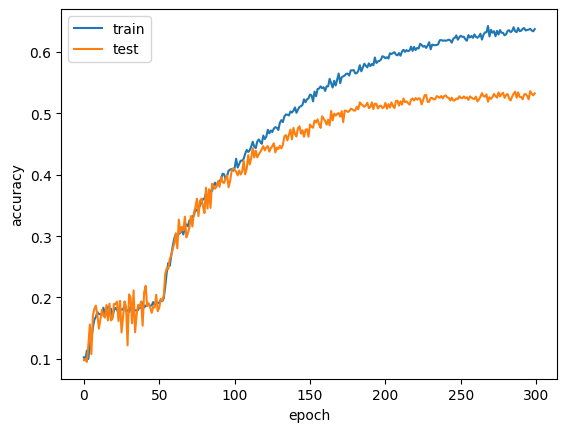

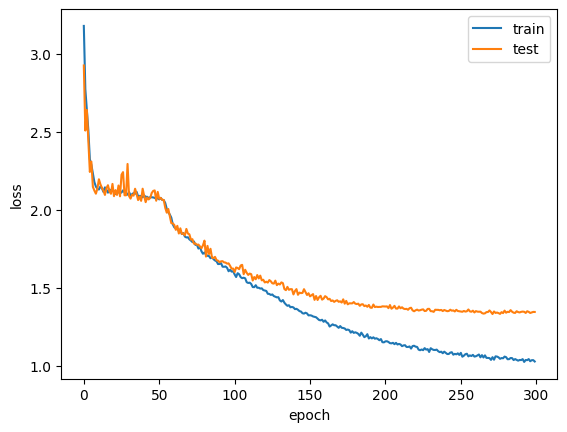

In [11]:
plt.plot(train_accuracy_h, label='train')
plt.plot(test_accuracy_h, label='test')
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.plot(train_loss_h, label='train')
plt.plot(test_loss_h, label='test')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [12]:
import pandas as pd
dict = {'train_acc': train_accuracy_h, 'test_acc': test_accuracy_h, 'train_loss': train_loss_h, 'test_loss' : test_loss_h}
df = pd.DataFrame(dict)
df.to_csv('logs/best_resnet_CIFAR10-DVS_Hardtanh_ReLUmaxpool_128x128_FC2_128x128_pretrained_aug_corrected_trilinear2.csv')

In [13]:
df.head()

,train_acc,test_acc,train_loss,test_loss
0,0.102571,0.098000,3.179686,2.926219
1,0.097571,0.100000,2.773847,2.509148
2,0.113429,0.095000,2.641312,2.641620
3,0.099857,0.122667,2.511055,2.448113
4,0.124143,0.156000,2.324947,2.243940
